In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import pyodbc
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [ ]:
server = ''
database = ''
username = ''
password = ''
driver= 'SQL Server'
connection = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)

In [ ]:
ab_name = 'complex_vs_google'

In [ ]:
requestString_sessions = requestString_sessions = f'''...
'''
df = pd.read_sql_query(requestString_sessions,connection)
data = df[['split','closed']]
ab_summary =  df.pivot_table(values='closed', index='split', aggfunc=np.sum)
ab_summary['total'] =  df.pivot_table(values='closed', index='split', aggfunc=lambda x: len(x))
ab_summary['% closed'] = df.pivot_table(values='closed', index='split')
ab_summary

In [ ]:
A_closed = ab_summary.closed.iloc[0]
A_total = ab_summary.total.iloc[0]
p_A = A_closed / A_total
X_A = A_total*p_A

B_closed = ab_summary.closed.iloc[1]
B_total = ab_summary.total.iloc[1]
p_B = B_closed / B_total
X_B = B_total*p_B

n = B_total+A_total
P = (A_closed+B_closed)/n

In [ ]:
A_total=790
B_total=746
n = B_total+A_total

In [ ]:
alpha = 0.05
z_score = scipy.stats.norm.ppf(1 - alpha / 2.)
p = 0.5
p_hat = A_total/n

std_error = 0.5/np.sqrt(n)
m = z_score*std_error
left = p - m
right = p + m

print(left,right,p_hat)

0.47499525168564943 0.5250047483143506 0.5143229166666666


In [ ]:
eff = 100* (- p_A + p_B)

In [ ]:
conf_interval_model_a = proportion_confint(sum(df.closed[df.split==0]),
                                            len(df.closed[df.split==0]),
                                            method = 'wilson')
conf_interval_model_b = proportion_confint(sum(df.closed[df.split==1]),
                                            len(df.closed[df.split==1]),
                                            method = 'wilson')

print (conf_interval_model_a,conf_interval_model_b)

(0.4786994738984239, 0.4940219741276434) (0.49370820235814716, 0.5092453870508611)


In [ ]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)

    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))

    return (left_boundary, right_boundary)

ci_diff = proportions_diff_confint_ind(df.closed[df.split==1], df.closed[df.split==0])

print(ci_diff)

(0.004207523017541461, 0.02603174226047511)


In [ ]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)

    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    P = float(p1*n1 + p2*n2) / (n1 + n2)

    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

z = proportions_diff_z_stat_ind(df.closed[df.split==0], df.closed[df.split==1])

print(z)

-2.7153957298111777


In [ ]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")

    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))

    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

z_greater = proportions_diff_z_test(z, 'greater')
z_less = proportions_diff_z_test(z, 'less')
z_two_sided = proportions_diff_z_test(z, 'two-sided')

print(z_greater,z_less,z_two_sided)


0.9966901690995134 0.0033098309004866975 0.006619661800973287


Text(0, 0.5, 'probability')

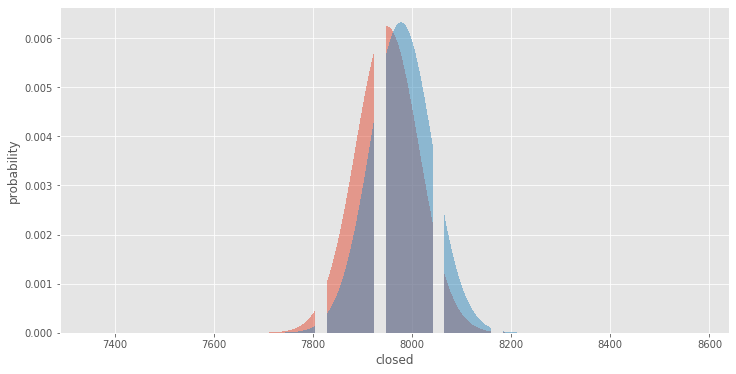

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_closed-599, A_closed+600, 1200)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_closed-599, B_closed+600, 1200)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('closed')
plt.ylabel('probability')

In [ ]:
# среднеквадротическое отклонение
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)

alpha = 0.05
z_score = scipy.stats.norm.ppf(1 - alpha)
m_a = z_score*SE_A
right_a = p_A + m_a

power = 1 - scs.norm(p_B, SE_B).cdf(right_a)

print(power)

0.9858102960948021


Text(0, 0.5, 'PDF')

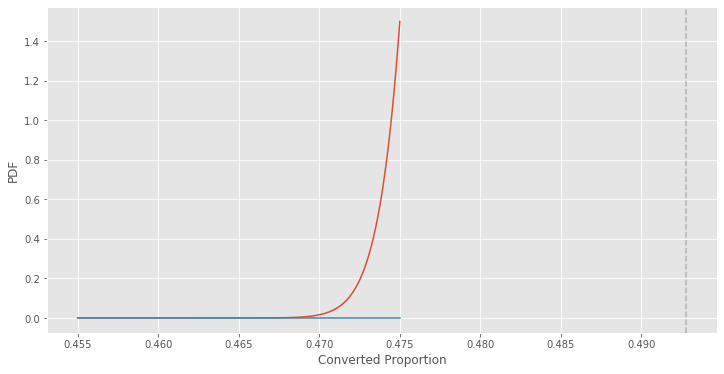

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0.455, 0.475, 1000)
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(x, yA)
ax.axvline(x=right_a, c='grey', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(x, yB)
ax.fill_between(x, 0, yB, color='green', alpha='0.25', where=(x > right_a))
plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

In [ ]:
print('Общая статистика:', '\n', ab_summary, '\n\n',
      'Полученный эффект:', '\n', "{:.2f}".format(eff)+'%', '\n\n',
      'Проверка объема выборок:', '\n',
      'Доверительный интервал для p=0.5: '+"{:.4f}".format(left)+'-'+"{:.4f}".format(right), '\n',
      'Доля сессий, ушедших на новую модель: ' +"{:.4f}".format(p_hat), '\n',
      'Если доля лежит внутри доверительного интервала, то сплит был корректным.', '\n\n',
      'Проверка пересечения доверительных интервалов для долей закрытых сессий:', '\n',
      'Доверительный интервал модели A: ' + str(conf_interval_model_a), '\n',
      'Доверительный интервал модели B: ' + str(conf_interval_model_b), '\n',
      'Если доверительные интервалы пересекаются, то модели отличаются незначительно.', '\n\n',
      'Проверка доверительного интервала разности долей:', '\n',
      'Доверительный интервал разницы долей: ' + str(ci_diff), '\n',
      'Если доверительный интервал содержит 0, то модели отличаются незначительно.', '\n\n',
      'Проверка p_value (вероятность найти эфффект, если его нет):', '\n',
      'p_value для гипотезы, что автоматизация модели В выше: ' +"{:.4f}".format(z_less), '\n',
      'Если p_value<0.05, то гипотеза принимается.', '\n\n',
      'Проверка мощности (вероятность найти эфффект, если он есть):', '\n',
      'мощность для гипотезы, что автоматизация модели В выше: ' +"{:.4f}".format(power), '\n',
      'Если мощность>0.8, то гипотезу можно принять.', '\n\n',
       )

Общая статистика: 
        closed  total  % closed
split                         
0.0      7950  16346  0.486358
1.0      7978  15909  0.501477 

 Полученный эффект: 
 1.51% 

 Проверка объема выборок: 
 Доверительный интервал для p=0.5: 0.4945-0.5055 
 Доля сессий, ушедших на новую модель: 0.5068 
 Если доля лежит внутри доверительного интервала, то сплит был корректным. 

 Проверка пересечения доверительных интервалов для долей закрытых сессий: 
 Доверительный интервал модели A: (0.4786994738984239, 0.4940219741276434) 
 Доверительный интервал модели B: (0.49370820235814716, 0.5092453870508611) 
 Если доверительные интервалы пересекаются, то модели отличаются незначительно. 

 Проверка доверительного интервала разности долей: 
 Доверительный интервал разницы долей: (0.004207523017541461, 0.02603174226047511) 
 Если доверительный интервал содержит 0, то модели отличаются незначительно. 

 Проверка p_value (вероятность найти эфффект, если его нет): 
 p_value для гипотезы, что автоматиз